In [1]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing as skp
from sklearn import model_selection as sms
from sklearn import feature_selection as skf
from sklearn import linear_model as slm
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
import nibabel as nib
import os
import pickle
from torch import nn
import gc
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 0
# Load data
nrows = 512
ncols = 512
nslices = 352
segs = []
qsms = []
laros = []
voxel_sizes = []
trackers = []
q_directory = '/home/ali/RadDBS-QSM/data/nii/new_qsm/'
q_directory = os.listdir(q_directory)
q_directory = sorted(q_directory)
s_directory = '/home/ali/RadDBS-QSM/data/nii/new_seg/'
s_directory = os.listdir(s_directory)
s_directory = sorted(s_directory)

n_cases = 115

In [4]:
cv_names = {'CORNELL ID',
            ' OFF (pre-dbs updrs)',
            ' ON (pre-dbs updrs)',
            ' OFF meds ON stim 6mo',
            'Age',
            'Sex',
            'Ethnicity',
            'Race',
            'Disease Duration (year)',
            'Physician',
            ' pre op levadopa equivalent dose (mg)',
            ' Location',
            ' Target',
            ' Test medication status'}


# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/dbs_03292024.csv'
motor_df = util.filter_data(file_dir,cv_names,True)
# Find cases with all required scores
cv_dict = util.filter_cases(motor_df,cv_names)
subs = cv_dict['CORNELL ID']
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/news/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/news/phi/'
roi_path = '/home/ali/RadDBS-QSM/data/xlxs/new_segs.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,all_rois)
# print(np.unique(R_all))
ids = np.asarray(ID_all).astype(int)

# Use cases from only 1 rater
phys = cv_dict['Physician']
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(ids).astype(int),np.asarray(cv_dict['CORNELL ID']).astype(int))
print('Cases:',c_cases)
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
# Exclude GPi
# c_cases_idx[ids == 36] = 0
# c_cases_idx[ids == 53] = 0
# c_cases_idx[ids == 98] = 0
# c_cases_idx[ids == 108] = 0

c_cases_idx[ids == 9] = 0
print(np.sum(c_cases_idx))
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
print(c_cases == subs[s_cases_idx])     
X_all_c = X_all[c_cases_idx,2:6,:]
K_all_c = K_all[c_cases_idx,2:6,:]
R_all_c = R_all[c_cases_idx,2:6,:]
# Re-index the scored subjects with respect to complete cases

per_change = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' OFF meds ON stim 6mo'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
pre_imp = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' ON (pre-dbs updrs)'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
pre_updrs = cv_dict[' OFF (pre-dbs updrs)'][s_cases_idx]
dd = cv_dict['Disease Duration (year)'][s_cases_idx]
ledd = cv_dict[' pre op levadopa equivalent dose (mg)'][s_cases_idx]
tmed = cv_dict[' Test medication status'][s_cases_idx]
phys = cv_dict['Physician'][s_cases_idx]
age = cv_dict['Age'][s_cases_idx]
loc = cv_dict[' Location'][s_cases_idx]
sex = cv_dict['Sex'][s_cases_idx]
rce = cv_dict['Race'][s_cases_idx]
eth = cv_dict['Ethnicity'][s_cases_idx]
tgt = cv_dict[' Target'][s_cases_idx]
subsc = subs[s_cases_idx]
# Reshape keys and ROIs
if all_rois == True:
    K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=object)
    K_all_cu[:,:,:-1] = K_all_c
    K_all_cu[:,:,-1] = 'pre_updrs'
    K_all_cu[:,:,-1] = 'disease_duration'
    K_all_cu[:,:,-1] = 'pre op levadopa equivalent dose (mg)'
    K_all_cu[:,:,-1] = ' Test medication status'
    K_all_cu[:,:,-1] = 'Physician'
    K_all_cu[:,:,-1] = 'Age'
    K_all_cu[:,:,-1] = 'Location'
    K_all_cu[:,:,-1] = 'Sex'
    K_all_cu[:,:,-1] = 'Race'
    K_all_cu[:,:,-1] = 'Ethnicity'
    
    K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))
else:
    K_all_c = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2]))[0]
    R_all_c = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))

# print(np.unique(R_all_c))

Keeping CORNELL ID
Keeping Age
Keeping Sex
Keeping Ethnicity
Keeping Race
Keeping Disease Duration (year)
Keeping Physician
Keeping  OFF (pre-dbs updrs)
Keeping  ON (pre-dbs updrs)
Keeping  pre op levadopa equivalent dose (mg)
Keeping  Location
Keeping  Target
Keeping  Test medication status
Keeping  OFF meds ON stim 6mo
{'Sex', ' ON (pre-dbs updrs)', 'Physician', ' OFF meds ON stim 6mo', 'Disease Duration (year)', ' pre op levadopa equivalent dose (mg)', ' Location', ' Target', 'CORNELL ID', ' OFF (pre-dbs updrs)', 'Ethnicity', 'Age', ' Test medication status', 'Race'}
['K_001.npy', 'K_002.npy', 'K_003.npy', 'K_004.npy', 'K_005.npy', 'K_006.npy', 'K_007.npy', 'K_008.npy', 'K_009.npy', 'K_010.npy', 'K_011.npy', 'K_012.npy', 'K_013.npy', 'K_014.npy', 'K_015.npy', 'K_016.npy', 'K_017.npy', 'K_018.npy', 'K_019.npy', 'K_020.npy', 'K_022.npy', 'K_023.npy', 'K_024.npy', 'K_025.npy', 'K_026.npy', 'K_027.npy', 'K_029.npy', 'K_030.npy', 'K_031.npy', 'K_032.npy', 'K_033.npy', 'K_034.npy', 'K_036

/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [5]:
ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  22,  23,  24,  25,  26,  27,
        29,  30,  31,  32,  33,  34,  36,  37,  39,  40,  41,  42,  44,
        45,  46,  48,  49,  50,  51,  52,  53,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  92,  93,  94,  95,  97,  98,  99, 100, 101,
       102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116])

In [6]:
subs

array([  1.,   2.,   6.,   7.,   9.,  10.,  11.,  15.,  16.,  19.,  20.,
        23.,  26.,  29.,  30.,  33.,  36.,  44.,  45.,  46.,  47.,  48.,
        51.,  53.,  55.,  56.,  58.,  59.,  60.,  62.,  63.,  64.,  66.,
        68.,  69.,  70.,  71.,  72.,  73.,  75.,  77.,  78.,  79.,  80.,
        83.,  85.,  86.,  87.,  90.,  91.,  92.,  93.,  95.,  96.,  97.,
        98., 100., 102., 103., 106., 107., 108., 109., 110., 111., 112.,
       113., 114., 115.])

In [7]:
subsc

array([  1.,   2.,   6.,   7.,  10.,  11.,  15.,  16.,  19.,  20.,  23.,
        26.,  29.,  30.,  33.,  36.,  44.,  45.,  46.,  48.,  51.,  53.,
        55.,  56.,  58.,  59.,  60.,  62.,  63.,  64.,  66.,  68.,  69.,
        70.,  71.,  72.,  73.,  75.,  77.,  78.,  79.,  80.,  83.,  85.,
        86.,  87.,  90.,  92.,  93.,  95.,  97.,  98., 100., 102., 106.,
       107., 108., 109., 110., 111., 112., 113., 114., 115.])

In [8]:
pre_updrs

array([65., 22., 63., 31., 42., 48., 46., 33., 30., 27., 50., 77., 32.,
       56., 33., 59., 52., 32., 33., 65., 33., 58., 63., 40., 58., 39.,
       37., 62., 34., 65., 32., 55., 35., 50., 46., 23., 48., 62., 59.,
       40., 29., 44., 56., 34., 58., 35., 43., 57., 55., 25., 40., 60.,
       45., 27., 59., 47., 32., 58., 61., 59., 54., 38., 40., 39.])

In [9]:
motor_df.insert(len(motor_df.columns), "Improvement", np.round((motor_df[' OFF (pre-dbs updrs)'].values.astype(float)-motor_df[' OFF meds ON stim 6mo'].values.astype(float))/motor_df[' OFF (pre-dbs updrs)'].values.astype(float),2), True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(motor_df)

CORNELL ID Age Sex Ethnicity Race Disease Duration (year) Physician  \
1           1  63   0         2    0                       5         2   
2           2  66   0         2    2                       7         5   
3           6  46   0         2    2                       8         1   
4           7  74   0         2    2                      11         0   
5           9  69   0         2    2                       7         1   
6          10  61   1         2    2                       7         5   
7          11  30   1         1    0                      10         3   
8          15  68   0         2    2                       2         1   
9          16  66   0         2    2                       5         5   
10         19  80   1         2    2                       2         2   
11         20  55   0         2    2                       8         4   
12         23  73   1         2    2                      15         1   
13         26  61   0         0    0                      15         1   
14         29  58   0         2    2                       8         1   
15         30  55   1         1    0                       6         1   
16         33  54   0         2    2                    15.5         0   
17         36  63   0         2    2                       5         1   
18         44  64   0         2    2                       6         1   
19         45  59   0         1    0                       8         1   
20         46  67   0         2    2                       3         1   
21         47  75   0         2    2                      20         0   
22         48  65   0         1    0                       8         1   
23         51  56   0         2    2                    10.5         5   
24         53  62   0         2    2                      25         1   
25         55  58   0         2    2                      11         1   
26         56  72   0         2    3                       6         2   
27         58  69   1         1    2                      11         1   
28         59  67   0         2    2                       6         1   
29         60  71   0         2    2                       5         2   
30         62  65   0         1    0                       7         1   
31         63  63   0         1    0                       6         1   
32         64  59   0         2    4                       7         5   
33         66  69   0         2    2                       6         5   
34         68  72   1         1    0                      15         1   
35         69  59   0         1    0                       8         2   
36         70  66   0         2    2                       9         5   
37         71  72   1         0    3                       8         5   
38         72  77   1         2    2                      14         5   
39         73  57   0         2    3                       3         1   
40         75  53   0         1    2                       7         1   
41         77  62   1         2    1                       7         5   
42         78  51   1         2    2                      10         2   
43         79  55   1         2    2                       6         2   
44         80  55   1         2    2                       6         5   
45         83  45   0         1    0                       7         1   
46         85  66   0         2    2                      15         1   
47         86  60   0         1    0                       6         2   
48         87  72   1         0    0                       7         1   
49         90  61   0         1    0                      15         1   
50         91  62   0         2    2                       6         5   
51         92  66   0         2    2                       5         1   
52         93  72   0         2    2                       9         5   
53         95  63   0         0    2                       6         2   
54     

In [10]:
n_cases = len(per_change)
results_ls_aug = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)

In [11]:
plt.imshow((X_all_c[:,:,:].reshape(-1,1595).astype(float)),cmap='viridis')
plt.colorbar()
plt.show()
X = skp.StandardScaler().fit_transform(X_all_c.reshape(X_all_c.shape[0],-1))
plt.imshow((X[:,:].reshape(-1,1595).astype(float)),cmap='viridis')
plt.colorbar()
plt.show()

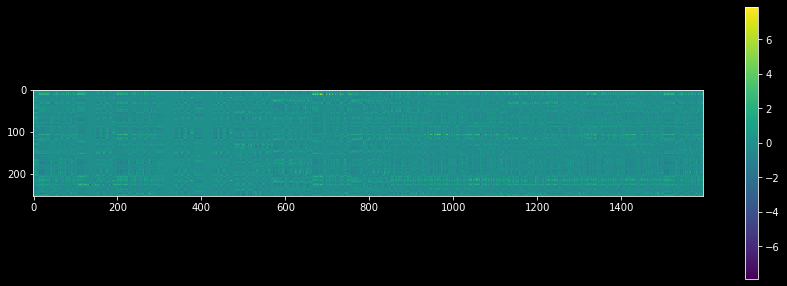

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1)
LassoCV score for 3 is [0.85598998] from dataset of size (68, 3381)
LassoCV score for 4 is [0.87290282] from dataset of size (68, 3381)
LassoCV score for 5 is [0.83930005] from dataset of size (68, 6381)
LassoCV score for 6 is [0.98651706] from dataset of size (68, 5381)
LassoCV score for 7 is [0.77057324] from dataset of size (68, 6381)
LassoCV score for 8 is [0.8941031] from dataset of size (68, 6381)
LassoCV score for 9 is [0.85944815] from dataset of size (68, 6381)
Lasso predicts 0.6448 for case with 0.71 with selected CV 6 6381 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.09069284] from dataset of size (68, 1)
LassoCV score for 3 is [0.59479318] from dataset of size (68, 4381)
LassoCV score for 4 is [0.86313828] from dataset of size (68, 4381)
LassoCV score for 5 is [0.77852523] from dataset of size (68, 6381)
LassoCV score for 6 is [0.89377358] from dataset of size (68, 5381)
LassoCV score for 7 is [0.84692568] from dataset of size (68, 3381)
LassoCV score for 8 is [0.74633967] from dataset of size (68, 6381)
LassoCV score for 9 is [0.7712749] from dataset of size (68, 6381)
Lasso predicts 0.6359 for case with 0.5 with selected CV 6 6381 features and 10 minority cases


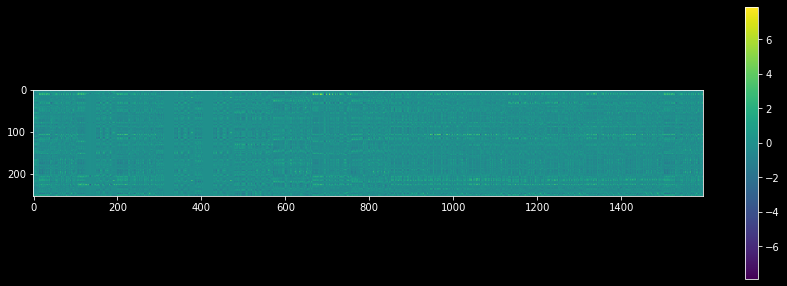

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1)
LassoCV score for 3 is [0.48399891] from dataset of size (68, 5381)
LassoCV score for 4 is [0.94669135] from dataset of size (68, 2381)
LassoCV score for 5 is [0.74536216] from dataset of size (68, 6381)
LassoCV score for 6 is [0.80659518] from dataset of size (68, 6381)
LassoCV score for 7 is [0.74506653] from dataset of size (68, 6381)
LassoCV score for 8 is [0.81732245] from dataset of size (68, 6381)
LassoCV score for 9 is [0.81539817] from dataset of size (68, 6381)
Lasso predicts 0.534 for case with 0.67 with selected CV 4 1 features and 10 minority cases


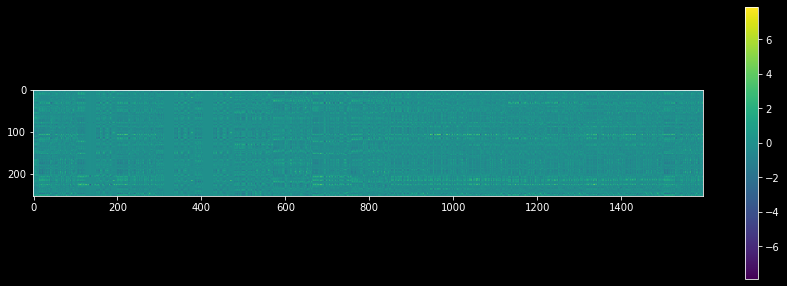

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.09151377] from dataset of size (68, 1)
LassoCV score for 3 is [0.99999302] from dataset of size (68, 2381)
LassoCV score for 4 is [0.78293383] from dataset of size (68, 4381)
LassoCV score for 5 is [0.78017759] from dataset of size (68, 6381)
LassoCV score for 6 is [0.81332367] from dataset of size (68, 6381)
LassoCV score for 7 is [0.7559268] from dataset of size (68, 6381)
LassoCV score for 8 is [0.78261328] from dataset of size (68, 6381)
LassoCV score for 9 is [0.80846962] from dataset of size (68, 6381)
Lasso predicts 0.6259 for case with 0.77 with selected CV 3 1 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.0934172] from dataset of size (68, 1)
LassoCV score for 3 is [0.0934172] from dataset of size (68, 1)
LassoCV score for 4 is [0.96539429] from dataset of size (68, 3381)
LassoCV score for 5 is [0.89421052] from dataset of size (68, 4381)
LassoCV score for 6 is [0.97379514] from dataset of size (68, 5381)
LassoCV score for 7 is [0.84218078] from dataset of size (68, 5381)
LassoCV score for 8 is [0.81181114] from dataset of size (68, 6381)
LassoCV score for 9 is [0.82934456] from dataset of size (68, 6381)
Lasso predicts 0.5513 for case with 0.74 with selected CV 6 1 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1)
LassoCV score for 3 is [0.74564761] from dataset of size (68, 3381)
LassoCV score for 4 is [0.9181304] from dataset of size (68, 3381)
LassoCV score for 5 is [0.83397194] from dataset of size (68, 6381)
LassoCV score for 6 is [0.69408004] from dataset of size (68, 6381)
LassoCV score for 7 is [0.78705356] from dataset of size (68, 6381)
LassoCV score for 8 is [0.81130335] from dataset of size (68, 5381)
LassoCV score for 9 is [0.80585979] from dataset of size (68, 6381)
Lasso predicts 0.6131 for case with 0.71 with selected CV 4 1 features and 10 minority cases


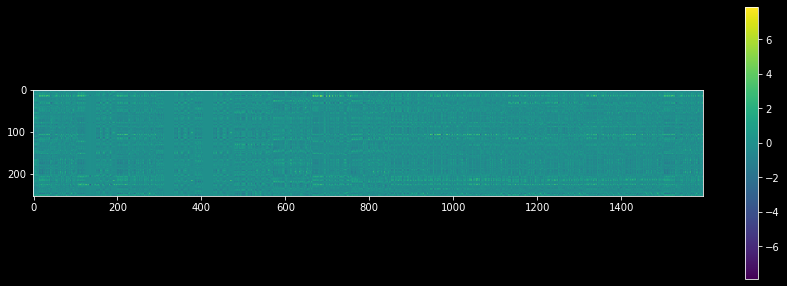

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1)
LassoCV score for 3 is [0.0839741] from dataset of size (68, 1)
LassoCV score for 4 is [0.61160122] from dataset of size (68, 6381)
LassoCV score for 5 is [0.82242832] from dataset of size (68, 5381)
LassoCV score for 6 is [0.83323724] from dataset of size (68, 5381)
LassoCV score for 7 is [0.75800202] from dataset of size (68, 6381)
LassoCV score for 8 is [0.81535686] from dataset of size (68, 6381)
LassoCV score for 9 is [0.79722975] from dataset of size (68, 6381)
Lasso predicts 0.6149 for case with 0.78 with selected CV 6 6381 features and 10 minority cases


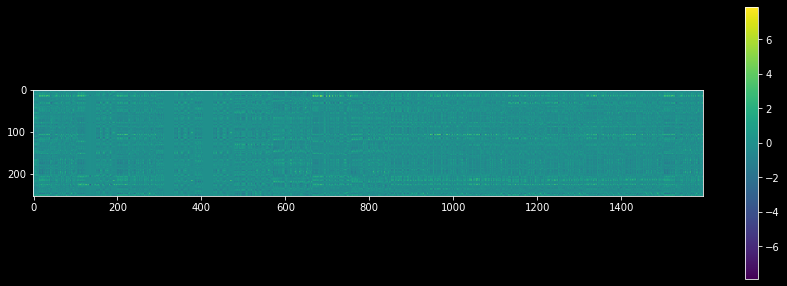

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1)
LassoCV score for 3 is [0.45773166] from dataset of size (68, 5381)
LassoCV score for 4 is [0.95186451] from dataset of size (68, 2381)
LassoCV score for 5 is [0.58510187] from dataset of size (68, 6381)
LassoCV score for 6 is [0.58284583] from dataset of size (68, 6381)
LassoCV score for 7 is [0.7746863] from dataset of size (68, 6381)
LassoCV score for 8 is [0.81173842] from dataset of size (68, 5381)
LassoCV score for 9 is [0.80942609] from dataset of size (68, 6381)
Lasso predicts 0.6642 for case with 0.85 with selected CV 4 2381 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1)
LassoCV score for 3 is [0.98049624] from dataset of size (68, 381)
LassoCV score for 4 is [0.90470829] from dataset of size (68, 4381)
LassoCV score for 5 is [0.82606138] from dataset of size (68, 6381)
LassoCV score for 6 is [0.79545444] from dataset of size (68, 6381)
LassoCV score for 7 is [0.74851249] from dataset of size (68, 6381)
LassoCV score for 8 is [0.92536023] from dataset of size (68, 5381)
LassoCV score for 9 is [0.83109675] from dataset of size (68, 6381)
Lasso predicts 0.6002 for case with 0.57 with selected CV 3 1 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 381)
LassoCV score for 3 is [0.52483749] from dataset of size (68, 5381)
LassoCV score for 4 is [0.82709841] from dataset of size (68, 5381)
LassoCV score for 5 is [0.82280064] from dataset of size (68, 6381)
LassoCV score for 6 is [0.75738972] from dataset of size (68, 6381)
LassoCV score for 7 is [0.78684388] from dataset of size (68, 6381)
LassoCV score for 8 is [0.817808] from dataset of size (68, 6381)
LassoCV score for 9 is [0.84603589] from dataset of size (68, 6381)
Lasso predicts 0.6806 for case with 0.74 with selected CV 9 6381 features and 10 minority cases


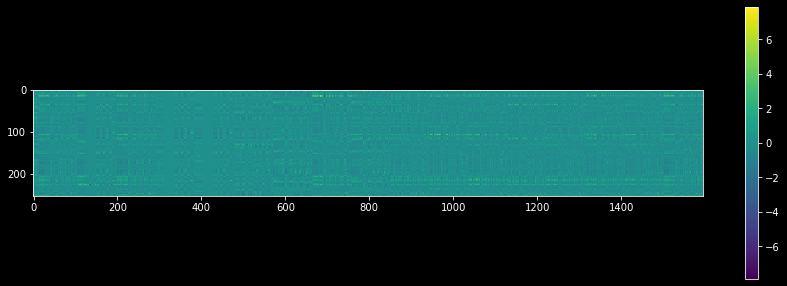

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.08556425] from dataset of size (68, 1)
LassoCV score for 3 is [0.74547524] from dataset of size (68, 5381)
LassoCV score for 4 is [0.67680464] from dataset of size (68, 6381)
LassoCV score for 5 is [0.08884797] from dataset of size (68, 1)
LassoCV score for 6 is [0.93175352] from dataset of size (68, 5381)
LassoCV score for 7 is [0.83543762] from dataset of size (68, 6381)
LassoCV score for 8 is [0.82918474] from dataset of size (68, 6381)
LassoCV score for 9 is [0.82605525] from dataset of size (68, 5381)
Lasso predicts 0.6176 for case with 0.48 with selected CV 6 1 features and 10 minority cases


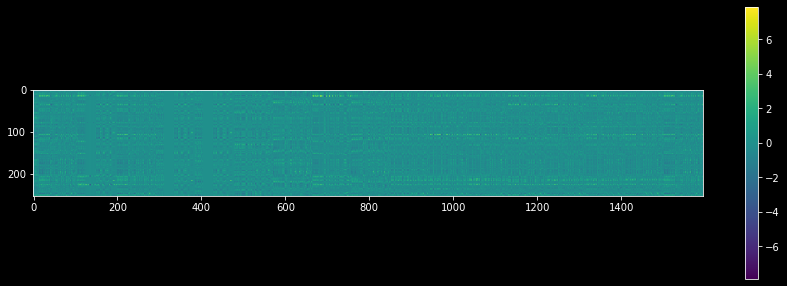

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1)
LassoCV score for 3 is [0.44170673] from dataset of size (68, 6381)
LassoCV score for 4 is [0.87279112] from dataset of size (68, 5381)
LassoCV score for 5 is [0.91185014] from dataset of size (68, 4381)
LassoCV score for 6 is [0.96901042] from dataset of size (68, 5381)
LassoCV score for 7 is [0.7999868] from dataset of size (68, 6381)
LassoCV score for 8 is [0.79940654] from dataset of size (68, 6381)
LassoCV score for 9 is [0.82031603] from dataset of size (68, 6381)
Lasso predicts 0.4814 for case with 0.71 with selected CV 6 1 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.01124595] from dataset of size (68, 381)
LassoCV score for 3 is [0.07866187] from dataset of size (68, 1)
LassoCV score for 4 is [0.66933022] from dataset of size (68, 6381)
LassoCV score for 5 is [0.83066871] from dataset of size (68, 5381)
LassoCV score for 6 is [0.86458656] from dataset of size (68, 4381)
LassoCV score for 7 is [0.7944535] from dataset of size (68, 6381)
LassoCV score for 8 is [0.84583524] from dataset of size (68, 5381)
LassoCV score for 9 is [0.84072866] from dataset of size (68, 3381)
Lasso predicts 0.7245 for case with 0.81 with selected CV 6 6381 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 381)
LassoCV score for 3 is [0.74187385] from dataset of size (68, 5381)
LassoCV score for 4 is [0.85055418] from dataset of size (68, 5381)
LassoCV score for 5 is [0.88267948] from dataset of size (68, 3381)
LassoCV score for 6 is [0.83428344] from dataset of size (68, 5381)
LassoCV score for 7 is [0.77757793] from dataset of size (68, 6381)
LassoCV score for 8 is [0.86459416] from dataset of size (68, 5381)
LassoCV score for 9 is [0.83733163] from dataset of size (68, 6381)
Lasso predicts 0.5522 for case with 0.82 with selected CV 5 5381 features and 10 minority cases


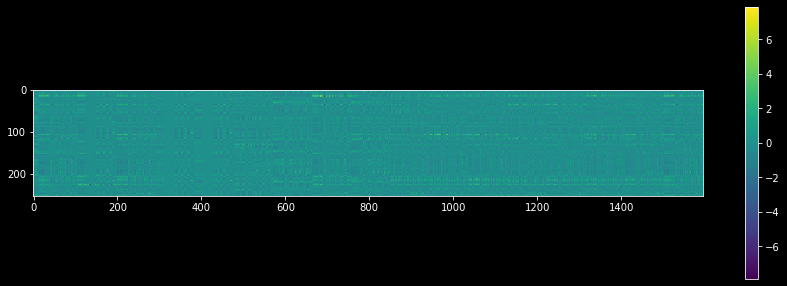

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.00081878] from dataset of size (68, 381)
LassoCV score for 3 is [0.52811798] from dataset of size (68, 5381)
LassoCV score for 4 is [0.85100375] from dataset of size (68, 5381)
LassoCV score for 5 is [0.77395424] from dataset of size (68, 6381)
LassoCV score for 6 is [0.89739762] from dataset of size (68, 4381)
LassoCV score for 7 is [0.79756251] from dataset of size (68, 6381)
LassoCV score for 8 is [0.83730104] from dataset of size (68, 5381)
LassoCV score for 9 is [0.82921034] from dataset of size (68, 6381)
Lasso predicts 0.535 for case with 0.67 with selected CV 6 6381 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.01296298] from dataset of size (68, 381)
LassoCV score for 3 is [0.45534359] from dataset of size (68, 5381)
LassoCV score for 4 is [0.75266896] from dataset of size (68, 4381)
LassoCV score for 5 is [0.90385569] from dataset of size (68, 4381)
LassoCV score for 6 is [0.78852331] from dataset of size (68, 5381)
LassoCV score for 7 is [0.79445682] from dataset of size (68, 6381)
LassoCV score for 8 is [0.83907846] from dataset of size (68, 5381)
LassoCV score for 9 is [0.85513313] from dataset of size (68, 6381)
Lasso predicts 0.6481 for case with 0.66 with selected CV 5 5381 features and 10 minority cases


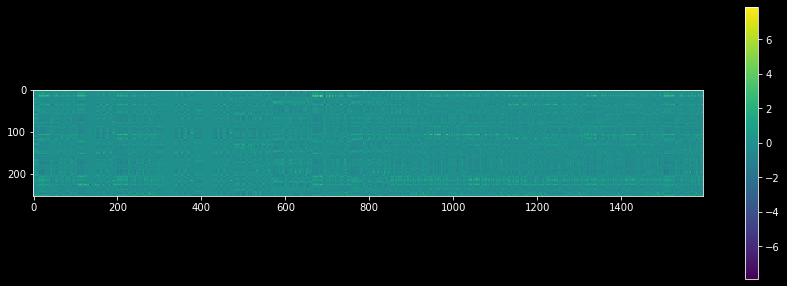

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 381)
LassoCV score for 3 is [0.99997119] from dataset of size (68, 2381)
LassoCV score for 4 is [0.99997445] from dataset of size (68, 381)
LassoCV score for 5 is [0.92276411] from dataset of size (68, 6381)
LassoCV score for 6 is [0.91083313] from dataset of size (68, 4381)
LassoCV score for 7 is [0.99976472] from dataset of size (68, 4381)
LassoCV score for 8 is [0.87041878] from dataset of size (68, 6381)
LassoCV score for 9 is [0.90754291] from dataset of size (68, 6381)
Lasso predicts 0.3942 for case with 0.88 with selected CV 4 3381 features and 10 minority cases


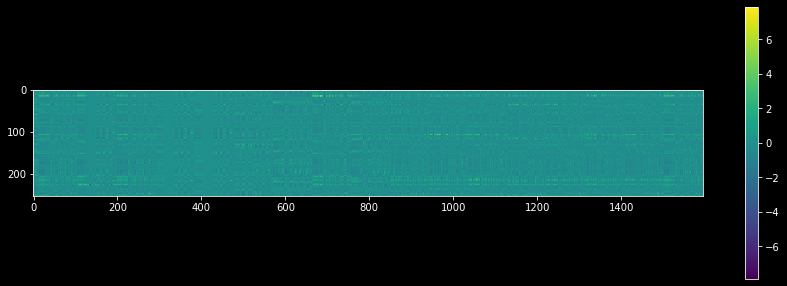

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
Resampled to size (69,)
LassoCV score for 2 is [0.03087108] from dataset of size (69, 1381)
LassoCV score for 3 is [0.90304731] from dataset of size (69, 4381)
LassoCV score for 4 is [0.99719666] from dataset of size (69, 3381)
LassoCV score for 5 is [0.91736239] from dataset of size (69, 5381)
LassoCV score for 6 is [0.96817987] from dataset of size (69, 6381)
LassoCV score for 7 is [0.99210205] from dataset of size (69, 5381)
LassoCV score for 8 is [0.91409624] from dataset of size (69, 6381)
LassoCV score for 9 is [0.92121402] from dataset of size (69, 6381)
Lasso predicts 0.5527 for case with 0.19 with selected CV 4 6381 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.00299601] from dataset of size (68, 381)
LassoCV score for 3 is [0.91992637] from dataset of size (68, 3381)
LassoCV score for 4 is [0.99194322] from dataset of size (68, 2381)
LassoCV score for 5 is [0.8325805] from dataset of size (68, 5381)
LassoCV score for 6 is [0.99771463] from dataset of size (68, 5381)
LassoCV score for 7 is [0.80162936] from dataset of size (68, 5381)
LassoCV score for 8 is [0.80169721] from dataset of size (68, 6381)
LassoCV score for 9 is [0.81201662] from dataset of size (68, 6381)
Lasso predicts 0.5817 for case with 0.85 with selected CV 6 1 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 381)
LassoCV score for 3 is [0.07873783] from dataset of size (68, 1)
LassoCV score for 4 is [0.99921176] from dataset of size (68, 2381)
LassoCV score for 5 is [0.94531275] from dataset of size (68, 5381)
LassoCV score for 6 is [0.90063753] from dataset of size (68, 3381)
LassoCV score for 7 is [0.84454654] from dataset of size (68, 6381)
LassoCV score for 8 is [0.88564723] from dataset of size (68, 5381)
LassoCV score for 9 is [0.83338879] from dataset of size (68, 6381)
Lasso predicts 0.3224 for case with 0.78 with selected CV 4 2381 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.01302906] from dataset of size (68, 381)
LassoCV score for 3 is [0.7265469] from dataset of size (68, 5381)
LassoCV score for 4 is [0.20180838] from dataset of size (68, 1)
LassoCV score for 5 is [0.83562913] from dataset of size (68, 6381)
LassoCV score for 6 is [0.82706341] from dataset of size (68, 5381)
LassoCV score for 7 is [0.20180838] from dataset of size (68, 1)
LassoCV score for 8 is [0.8109758] from dataset of size (68, 5381)
LassoCV score for 9 is [0.07027672] from dataset of size (68, 1)
Lasso predicts 0.5772 for case with 0.3 with selected CV 5 6381 features and 10 minority cases


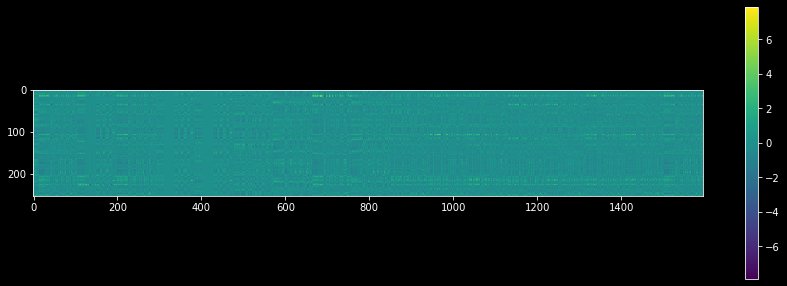

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1381)
LassoCV score for 3 is [0.54244223] from dataset of size (68, 6381)
LassoCV score for 4 is [0.67862846] from dataset of size (68, 6381)
LassoCV score for 5 is [0.74232339] from dataset of size (68, 6381)
LassoCV score for 6 is [0.75649064] from dataset of size (68, 5381)
LassoCV score for 7 is [0.7887934] from dataset of size (68, 6381)
LassoCV score for 8 is [0.79416867] from dataset of size (68, 5381)
LassoCV score for 9 is [0.73634181] from dataset of size (68, 6381)
Lasso predicts 0.7271 for case with 0.47 with selected CV 8 6381 features and 10 minority cases


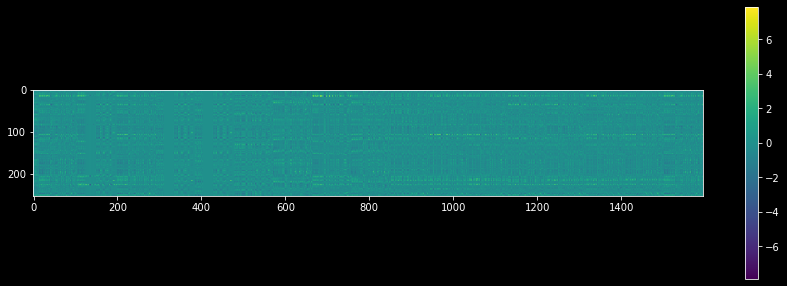

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1381)
LassoCV score for 3 is [0.42289588] from dataset of size (68, 5381)
LassoCV score for 4 is [0.07448952] from dataset of size (68, 1)
LassoCV score for 5 is [0.82419321] from dataset of size (68, 6381)
LassoCV score for 6 is [0.85469449] from dataset of size (68, 5381)
LassoCV score for 7 is [0.81216828] from dataset of size (68, 6381)
LassoCV score for 8 is [0.81779346] from dataset of size (68, 6381)
LassoCV score for 9 is [0.06985182] from dataset of size (68, 1)
Lasso predicts 0.711 for case with 0.89 with selected CV 6 6381 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
Resampled to size (69,)
LassoCV score for 2 is [0.00465827] from dataset of size (69, 1381)
LassoCV score for 3 is [0.91461777] from dataset of size (69, 5381)
LassoCV score for 4 is [0.9494018] from dataset of size (69, 4381)
LassoCV score for 5 is [0.968822] from dataset of size (69, 5381)
LassoCV score for 6 is [0.85753238] from dataset of size (69, 6381)
LassoCV score for 7 is [0.88467826] from dataset of size (69, 6381)
LassoCV score for 8 is [0.83975558] from dataset of size (69, 6381)
LassoCV score for 9 is [0.76572755] from dataset of size (69, 6381)
Lasso predicts 0.6175 for case with 0.08 with selected CV 5 6381 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.00486293] from dataset of size (68, 381)
LassoCV score for 3 is [0.76157604] from dataset of size (68, 2381)
LassoCV score for 4 is [0.70317336] from dataset of size (68, 5381)
LassoCV score for 5 is [0.98214096] from dataset of size (68, 1381)
LassoCV score for 6 is [0.84226478] from dataset of size (68, 5381)
LassoCV score for 7 is [0.81854762] from dataset of size (68, 6381)
LassoCV score for 8 is [0.8401005] from dataset of size (68, 5381)
LassoCV score for 9 is [0.09126572] from dataset of size (68, 1)
Lasso predicts 0.6671 for case with 0.52 with selected CV 5 4381 features and 10 minority cases


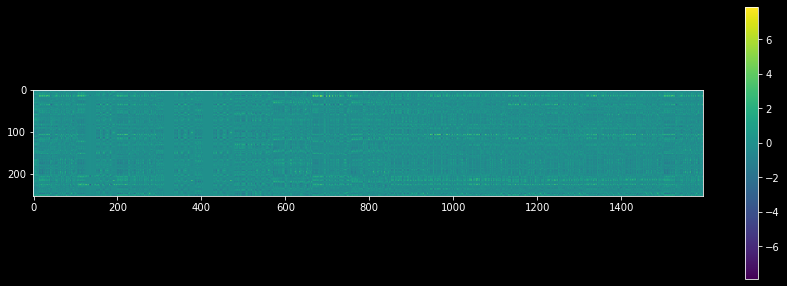

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.00211981] from dataset of size (68, 381)
LassoCV score for 3 is [0.5073565] from dataset of size (68, 6381)
LassoCV score for 4 is [0.77623318] from dataset of size (68, 5381)
LassoCV score for 5 is [0.82961423] from dataset of size (68, 6381)
LassoCV score for 6 is [0.89818471] from dataset of size (68, 5381)
LassoCV score for 7 is [0.81034791] from dataset of size (68, 6381)
LassoCV score for 8 is [0.83361265] from dataset of size (68, 4381)
LassoCV score for 9 is [0.76356814] from dataset of size (68, 6381)
Lasso predicts 0.6562 for case with 0.74 with selected CV 6 1 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1)
LassoCV score for 3 is [0.85287872] from dataset of size (68, 2381)
LassoCV score for 4 is [0.93073616] from dataset of size (68, 6381)
LassoCV score for 5 is [0.89648788] from dataset of size (68, 6381)
LassoCV score for 6 is [0.98221317] from dataset of size (68, 5381)
LassoCV score for 7 is [0.99998308] from dataset of size (68, 6381)
LassoCV score for 8 is [0.85862965] from dataset of size (68, 6381)
LassoCV score for 9 is [0.9363194] from dataset of size (68, 6381)
Lasso predicts 0.3074 for case with 0.81 with selected CV 7 2381 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.08908952] from dataset of size (68, 1)
LassoCV score for 3 is [0.55377827] from dataset of size (68, 3381)
LassoCV score for 4 is [0.90538971] from dataset of size (68, 3381)
LassoCV score for 5 is [0.84235838] from dataset of size (68, 6381)
LassoCV score for 6 is [0.99082939] from dataset of size (68, 4381)
LassoCV score for 7 is [0.85854352] from dataset of size (68, 6381)
LassoCV score for 8 is [0.84529757] from dataset of size (68, 5381)
LassoCV score for 9 is [0.85949505] from dataset of size (68, 6381)
Lasso predicts 0.8529 for case with 0.53 with selected CV 6 6381 features and 10 minority cases


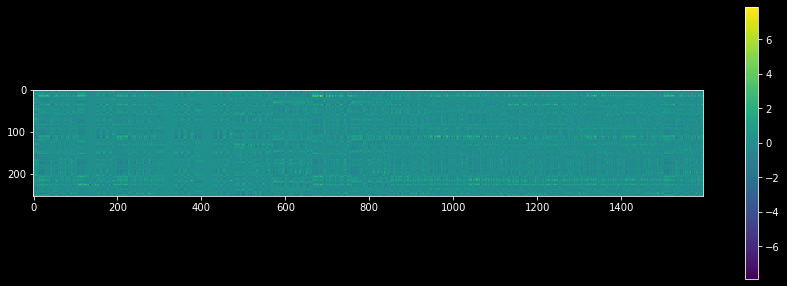

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.09551601] from dataset of size (68, 1)
LassoCV score for 3 is [0.67108542] from dataset of size (68, 4381)
LassoCV score for 4 is [0.8181871] from dataset of size (68, 6381)
LassoCV score for 5 is [0.81662504] from dataset of size (68, 6381)
LassoCV score for 6 is [0.73322067] from dataset of size (68, 6381)
LassoCV score for 7 is [0.87530123] from dataset of size (68, 6381)
LassoCV score for 8 is [0.88417984] from dataset of size (68, 5381)
LassoCV score for 9 is [0.82861761] from dataset of size (68, 6381)
Lasso predicts 0.5473 for case with 0.91 with selected CV 8 6381 features and 10 minority cases


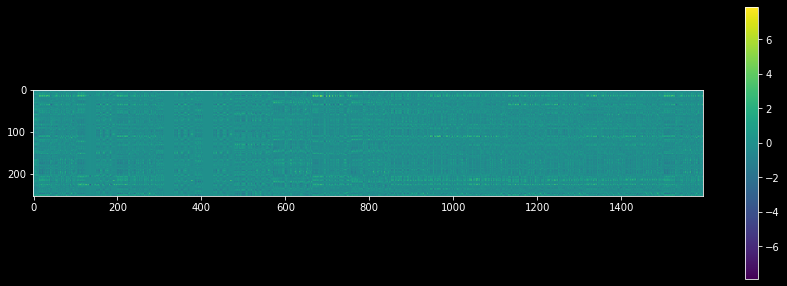

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1)
LassoCV score for 3 is [0.76276291] from dataset of size (68, 4381)
LassoCV score for 4 is [0.85132832] from dataset of size (68, 4381)
LassoCV score for 5 is [0.9871595] from dataset of size (68, 6381)
LassoCV score for 6 is [0.971516] from dataset of size (68, 5381)
LassoCV score for 7 is [0.9698651] from dataset of size (68, 3381)
LassoCV score for 8 is [0.99709246] from dataset of size (68, 4381)
LassoCV score for 9 is [0.86964605] from dataset of size (68, 6381)
Lasso predicts 0.3297 for case with 0.66 with selected CV 8 6381 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1)
LassoCV score for 3 is [0.50273752] from dataset of size (68, 3381)
LassoCV score for 4 is [0.80844637] from dataset of size (68, 4381)
LassoCV score for 5 is [0.96920958] from dataset of size (68, 6381)
LassoCV score for 6 is [0.73183719] from dataset of size (68, 6381)
LassoCV score for 7 is [0.83705252] from dataset of size (68, 6381)
LassoCV score for 8 is [0.78674892] from dataset of size (68, 6381)
LassoCV score for 9 is [0.76986551] from dataset of size (68, 6381)
Lasso predicts 0.5483 for case with 0.53 with selected CV 5 5381 features and 10 minority cases


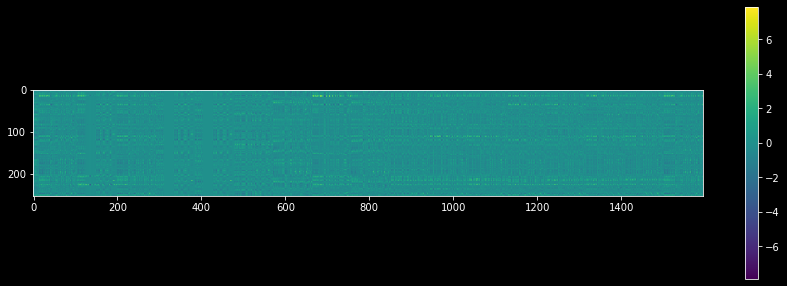

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1)
LassoCV score for 3 is [0.51026595] from dataset of size (68, 4381)
LassoCV score for 4 is [0.83490628] from dataset of size (68, 4381)
LassoCV score for 5 is [0.96494014] from dataset of size (68, 6381)
LassoCV score for 6 is [0.98701343] from dataset of size (68, 6381)
LassoCV score for 7 is [0.88196859] from dataset of size (68, 6381)
LassoCV score for 8 is [0.86319539] from dataset of size (68, 6381)
LassoCV score for 9 is [0.75800897] from dataset of size (68, 6381)
Lasso predicts 0.7612 for case with 0.8 with selected CV 6 6381 features and 10 minority cases


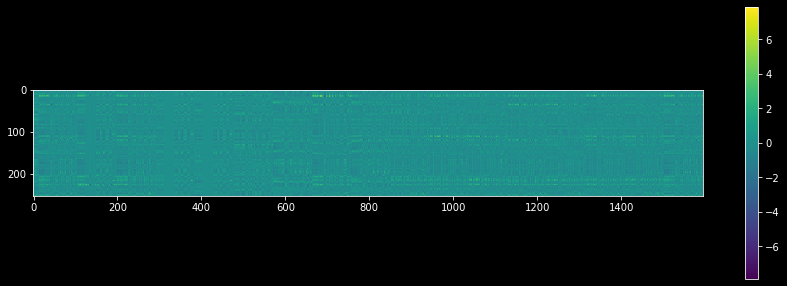

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1)
LassoCV score for 3 is [0.43165959] from dataset of size (68, 5381)
LassoCV score for 4 is [0.87157277] from dataset of size (68, 4381)
LassoCV score for 5 is [0.85561875] from dataset of size (68, 5381)
LassoCV score for 6 is [0.56905194] from dataset of size (68, 6381)
LassoCV score for 7 is [0.83501482] from dataset of size (68, 6381)
LassoCV score for 8 is [0.79387513] from dataset of size (68, 6381)
LassoCV score for 9 is [0.75752696] from dataset of size (68, 6381)
Lasso predicts 0.6017 for case with 0.89 with selected CV 4 4381 features and 10 minority cases


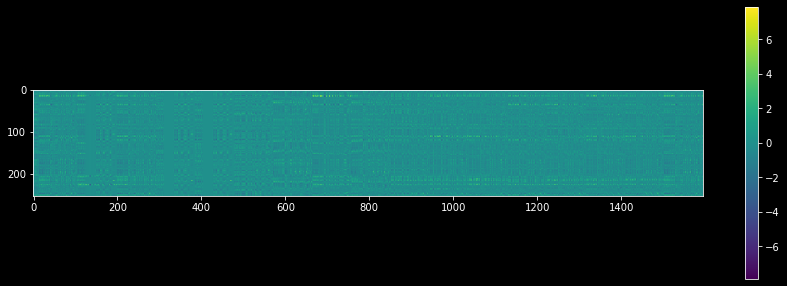

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.08556425] from dataset of size (68, 1)
LassoCV score for 3 is [0.49391454] from dataset of size (68, 5381)
LassoCV score for 4 is [0.90389208] from dataset of size (68, 6381)
LassoCV score for 5 is [0.82937186] from dataset of size (68, 5381)
LassoCV score for 6 is [0.5764046] from dataset of size (68, 6381)
LassoCV score for 7 is [0.85436331] from dataset of size (68, 6381)
LassoCV score for 8 is [0.87666501] from dataset of size (68, 6381)
LassoCV score for 9 is [0.86626948] from dataset of size (68, 6381)
Lasso predicts 0.8571 for case with 0.48 with selected CV 4 5381 features and 10 minority cases


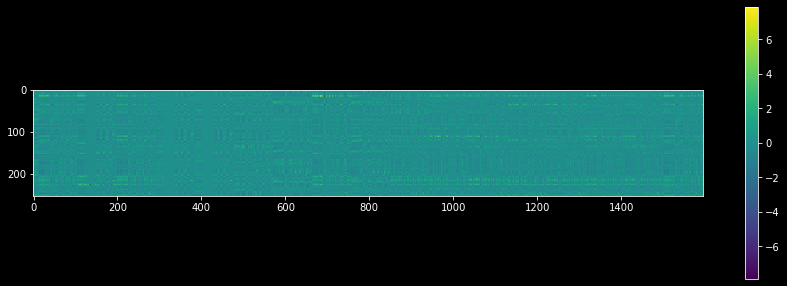

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1)
LassoCV score for 3 is [0.84282093] from dataset of size (68, 381)
LassoCV score for 4 is [0.57143809] from dataset of size (68, 6381)
LassoCV score for 5 is [0.8075097] from dataset of size (68, 6381)
LassoCV score for 6 is [0.69291761] from dataset of size (68, 6381)
LassoCV score for 7 is [0.16319303] from dataset of size (68, 1)
LassoCV score for 8 is [0.76685802] from dataset of size (68, 6381)
LassoCV score for 9 is [0.75205428] from dataset of size (68, 6381)
Lasso predicts 0.5885 for case with 0.76 with selected CV 3 1 features and 10 minority cases


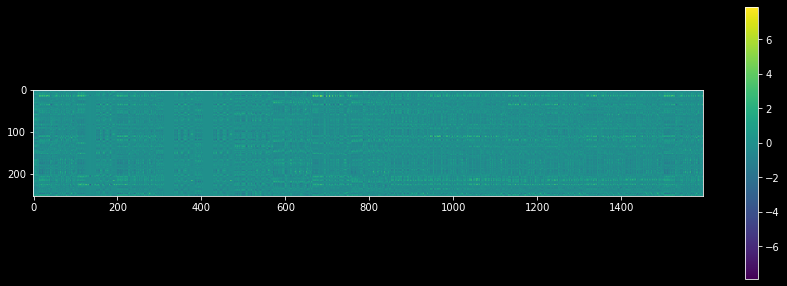

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
Resampled to size (69,)
LassoCV score for 2 is [0.] from dataset of size (69, 1)
LassoCV score for 3 is [0.90235785] from dataset of size (69, 6381)
LassoCV score for 4 is [0.98206841] from dataset of size (69, 5381)
LassoCV score for 5 is [0.84470122] from dataset of size (69, 6381)
LassoCV score for 6 is [0.80539405] from dataset of size (69, 6381)
LassoCV score for 7 is [0.93696947] from dataset of size (69, 5381)
LassoCV score for 8 is [0.90132471] from dataset of size (69, 5381)
LassoCV score for 9 is [0.84343541] from dataset of size (69, 5381)
Lasso predicts 0.5705 for case with 0.26 with selected CV 4 6381 features and 10 minority cases


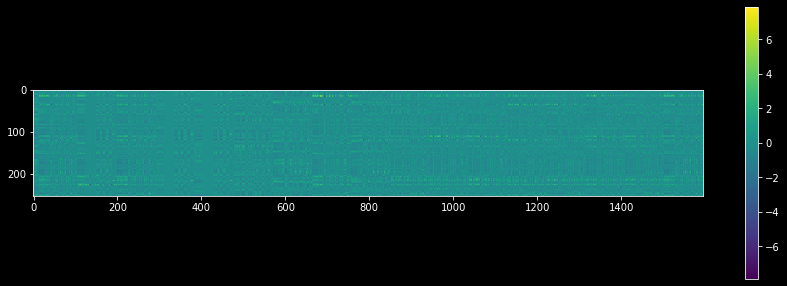

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 6381)
LassoCV score for 3 is [0.50261589] from dataset of size (68, 3381)
LassoCV score for 4 is [0.84414844] from dataset of size (68, 5381)
LassoCV score for 5 is [0.86400172] from dataset of size (68, 5381)
LassoCV score for 6 is [0.75374543] from dataset of size (68, 6381)
LassoCV score for 7 is [0.88587712] from dataset of size (68, 6381)
LassoCV score for 8 is [0.81067737] from dataset of size (68, 6381)
LassoCV score for 9 is [0.76467348] from dataset of size (68, 6381)
Lasso predicts 0.8401 for case with 0.81 with selected CV 7 5381 features and 10 minority cases


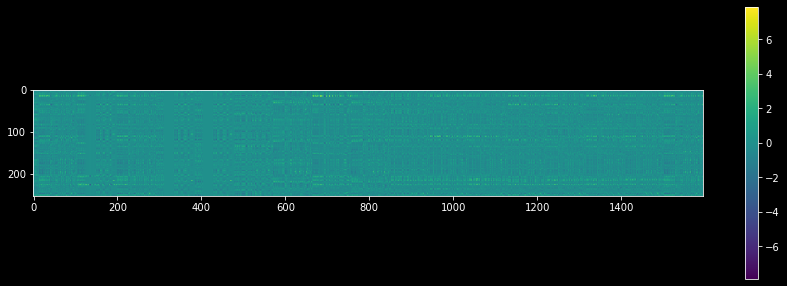

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 6381)
LassoCV score for 3 is [0.67555047] from dataset of size (68, 4381)
LassoCV score for 4 is [0.20009232] from dataset of size (68, 1)
LassoCV score for 5 is [0.98706173] from dataset of size (68, 4381)
LassoCV score for 6 is [0.99938936] from dataset of size (68, 6381)
LassoCV score for 7 is [0.72580732] from dataset of size (68, 6381)
LassoCV score for 8 is [0.99654319] from dataset of size (68, 5381)
LassoCV score for 9 is [0.69749484] from dataset of size (68, 6381)
Lasso predicts 0.4176 for case with 0.97 with selected CV 6 6381 features and 10 minority cases


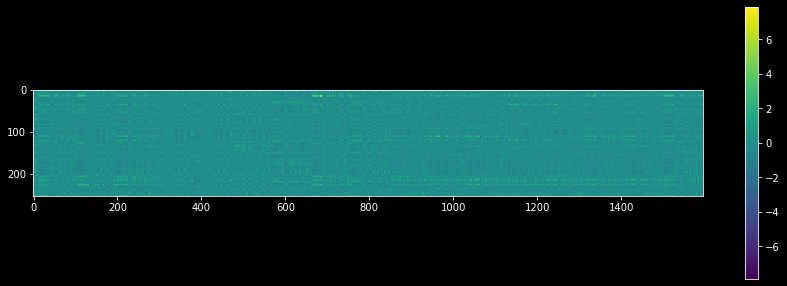

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 6381)
LassoCV score for 3 is [0.71093855] from dataset of size (68, 4381)
LassoCV score for 4 is [0.99449806] from dataset of size (68, 5381)
LassoCV score for 5 is [0.85515996] from dataset of size (68, 5381)
LassoCV score for 6 is [0.93311261] from dataset of size (68, 5381)
LassoCV score for 7 is [0.80287905] from dataset of size (68, 6381)
LassoCV score for 8 is [0.82605804] from dataset of size (68, 5381)
LassoCV score for 9 is [0.8061213] from dataset of size (68, 6381)
Lasso predicts 1.0032 for case with 0.56 with selected CV 4 6381 features and 10 minority cases


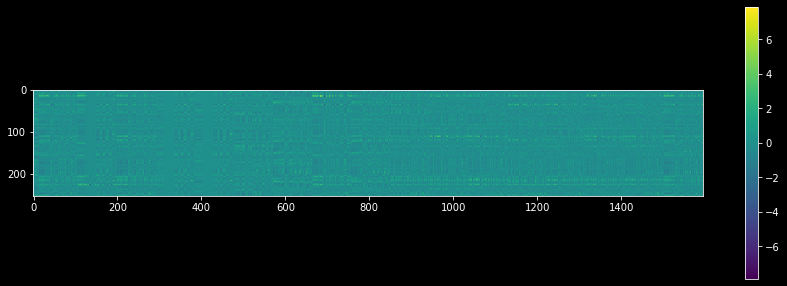

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 6381)
LassoCV score for 3 is [0.52449235] from dataset of size (68, 4381)
LassoCV score for 4 is [0.78966089] from dataset of size (68, 6381)
LassoCV score for 5 is [0.97367084] from dataset of size (68, 1381)
LassoCV score for 6 is [0.69739816] from dataset of size (68, 6381)
LassoCV score for 7 is [0.82880034] from dataset of size (68, 6381)
LassoCV score for 8 is [0.79610865] from dataset of size (68, 6381)
LassoCV score for 9 is [0.77267023] from dataset of size (68, 6381)
Lasso predicts 0.5535 for case with 0.65 with selected CV 5 6381 features and 10 minority cases


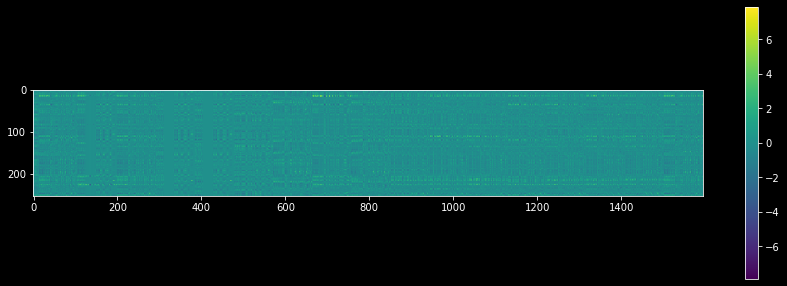

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 6381)
LassoCV score for 3 is [0.52280362] from dataset of size (68, 4381)
LassoCV score for 4 is [0.88142136] from dataset of size (68, 3381)
LassoCV score for 5 is [0.94011848] from dataset of size (68, 1381)
LassoCV score for 6 is [0.96626822] from dataset of size (68, 6381)
LassoCV score for 7 is [0.83757645] from dataset of size (68, 6381)
LassoCV score for 8 is [0.79132994] from dataset of size (68, 6381)
LassoCV score for 9 is [0.74025821] from dataset of size (68, 6381)
Lasso predicts 0.5833 for case with 0.66 with selected CV 6 6381 features and 10 minority cases


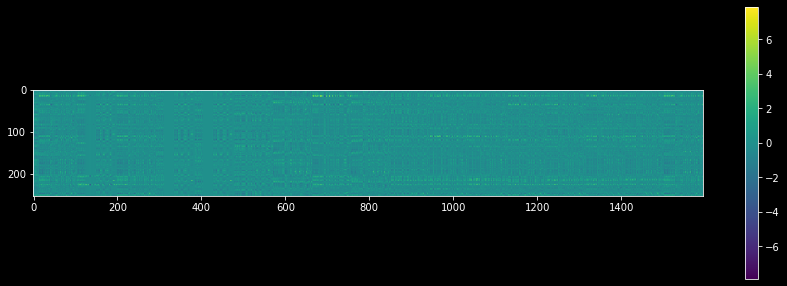

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 6381)
LassoCV score for 3 is [0.53863884] from dataset of size (68, 4381)
LassoCV score for 4 is [0.61464724] from dataset of size (68, 6381)
LassoCV score for 5 is [0.93269033] from dataset of size (68, 2381)
LassoCV score for 6 is [0.72957797] from dataset of size (68, 6381)
LassoCV score for 7 is [0.88248037] from dataset of size (68, 5381)
LassoCV score for 8 is [0.82478662] from dataset of size (68, 4381)
LassoCV score for 9 is [0.74585597] from dataset of size (68, 6381)
Lasso predicts 0.5544 for case with 0.52 with selected CV 5 6381 features and 10 minority cases


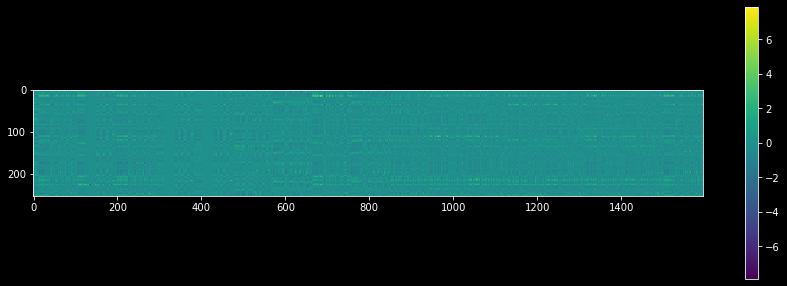

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 3381)
LassoCV score for 3 is [0.75685485] from dataset of size (68, 3381)
LassoCV score for 4 is [0.82721389] from dataset of size (68, 5381)
LassoCV score for 5 is [0.88095644] from dataset of size (68, 4381)
LassoCV score for 6 is [0.75342427] from dataset of size (68, 6381)
LassoCV score for 7 is [0.78487782] from dataset of size (68, 6381)
LassoCV score for 8 is [0.81593318] from dataset of size (68, 5381)
LassoCV score for 9 is [0.75299796] from dataset of size (68, 6381)
Lasso predicts 0.5729 for case with 0.84 with selected CV 5 5381 features and 10 minority cases


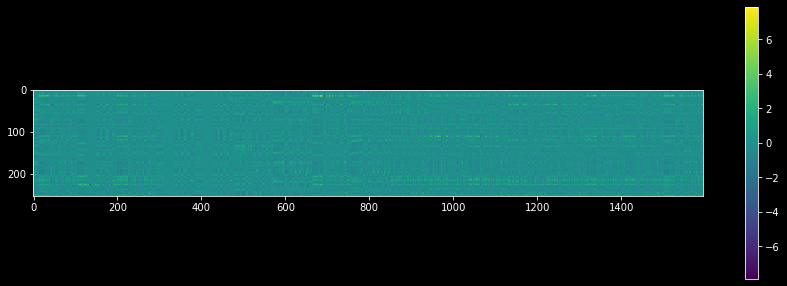

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
Resampled to size (69,)
LassoCV score for 2 is [0.0433333] from dataset of size (69, 6381)
LassoCV score for 3 is [0.9498559] from dataset of size (69, 1381)
LassoCV score for 4 is [0.742352] from dataset of size (69, 6381)
LassoCV score for 5 is [0.75702915] from dataset of size (69, 6381)
LassoCV score for 6 is [0.85172152] from dataset of size (69, 4381)
LassoCV score for 7 is [0.85796416] from dataset of size (69, 6381)
LassoCV score for 8 is [0.9465657] from dataset of size (69, 5381)
LassoCV score for 9 is [0.83031422] from dataset of size (69, 6381)
Lasso predicts 0.6137 for case with 0.15 with selected CV 3 6381 features and 10 minority cases


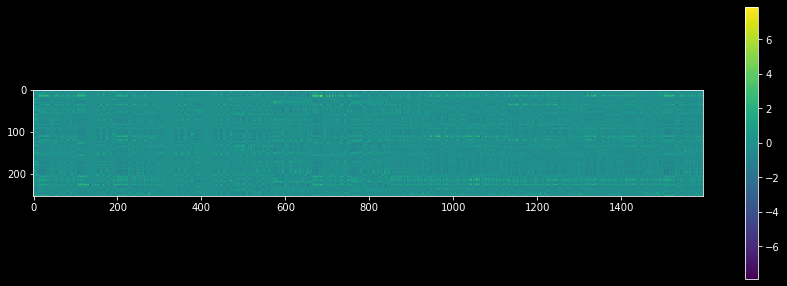

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 6381)
LassoCV score for 3 is [0.60454066] from dataset of size (68, 4381)
LassoCV score for 4 is [0.81429597] from dataset of size (68, 5381)
LassoCV score for 5 is [0.94561303] from dataset of size (68, 4381)
LassoCV score for 6 is [0.08133911] from dataset of size (68, 1)
LassoCV score for 7 is [0.91291557] from dataset of size (68, 5381)
LassoCV score for 8 is [0.83411125] from dataset of size (68, 5381)
LassoCV score for 9 is [0.7804139] from dataset of size (68, 6381)
Lasso predicts 0.6882 for case with 0.5 with selected CV 5 2381 features and 10 minority cases


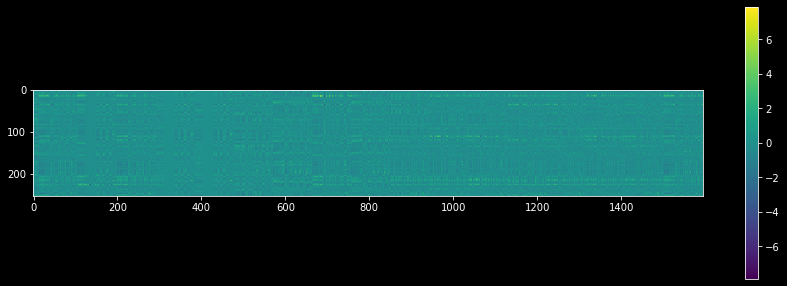

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
Resampled to size (69,)
LassoCV score for 2 is [0.24158462] from dataset of size (69, 381)
LassoCV score for 3 is [0.56341541] from dataset of size (69, 5381)
LassoCV score for 4 is [0.82268064] from dataset of size (69, 6381)
LassoCV score for 5 is [0.77862752] from dataset of size (69, 6381)
LassoCV score for 6 is [0.76959158] from dataset of size (69, 6381)
LassoCV score for 7 is [0.80533607] from dataset of size (69, 6381)
LassoCV score for 8 is [0.80750132] from dataset of size (69, 5381)
LassoCV score for 9 is [0.04041232] from dataset of size (69, 1)
Lasso predicts 0.4272 for case with 0.09 with selected CV 4 5381 features and 10 minority cases


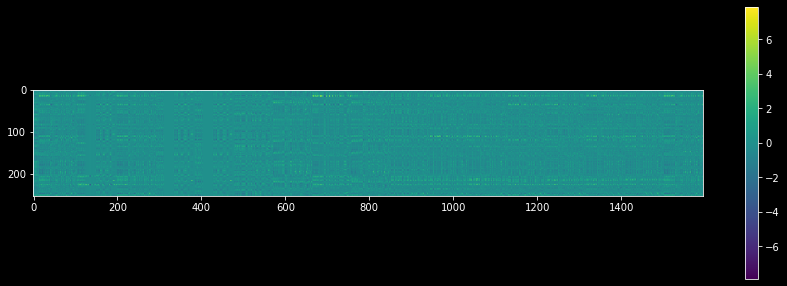

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 6381)
LassoCV score for 3 is [0.54600747] from dataset of size (68, 5381)
LassoCV score for 4 is [0.69690906] from dataset of size (68, 6381)
LassoCV score for 5 is [0.97547234] from dataset of size (68, 5381)
LassoCV score for 6 is [0.19258409] from dataset of size (68, 1)
LassoCV score for 7 is [0.81156525] from dataset of size (68, 6381)
LassoCV score for 8 is [0.99966792] from dataset of size (68, 4381)
LassoCV score for 9 is [0.81823549] from dataset of size (68, 6381)
Lasso predicts 0.666 for case with 0.3 with selected CV 8 6381 features and 10 minority cases


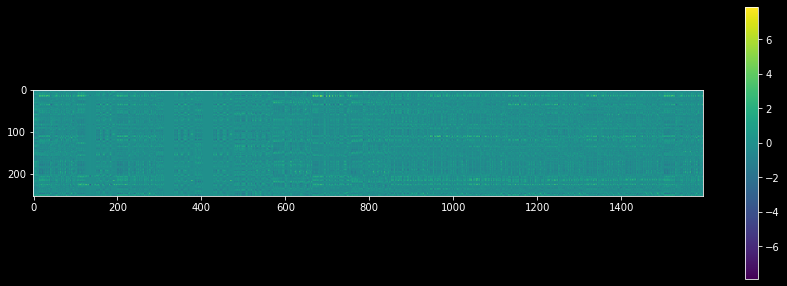

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 6381)
LassoCV score for 3 is [0.90974277] from dataset of size (68, 1381)
LassoCV score for 4 is [0.98655205] from dataset of size (68, 3381)
LassoCV score for 5 is [0.89860495] from dataset of size (68, 4381)
LassoCV score for 6 is [0.99505834] from dataset of size (68, 6381)
LassoCV score for 7 is [0.82450578] from dataset of size (68, 5381)
LassoCV score for 8 is [0.80106226] from dataset of size (68, 5381)
LassoCV score for 9 is [0.09260578] from dataset of size (68, 1)
Lasso predicts 0.6881 for case with 0.46 with selected CV 6 1 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 6381)
LassoCV score for 3 is [0.93723424] from dataset of size (68, 1381)
LassoCV score for 4 is [0.85126655] from dataset of size (68, 4381)
LassoCV score for 5 is [0.82836845] from dataset of size (68, 4381)
LassoCV score for 6 is [0.62128342] from dataset of size (68, 6381)
LassoCV score for 7 is [0.80514973] from dataset of size (68, 6381)
LassoCV score for 8 is [0.8571207] from dataset of size (68, 4381)
LassoCV score for 9 is [0.79239108] from dataset of size (68, 6381)
Lasso predicts 0.4581 for case with 0.64 with selected CV 3 3381 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1)
LassoCV score for 3 is [0.78423554] from dataset of size (68, 3381)
LassoCV score for 4 is [0.72193253] from dataset of size (68, 6381)
LassoCV score for 5 is [0.81453244] from dataset of size (68, 5381)
LassoCV score for 6 is [0.73497265] from dataset of size (68, 6381)
LassoCV score for 7 is [0.75833897] from dataset of size (68, 6381)
LassoCV score for 8 is [0.806168] from dataset of size (68, 6381)
LassoCV score for 9 is [0.76269572] from dataset of size (68, 6381)
Lasso predicts 0.6531 for case with 0.96 with selected CV 5 5381 features and 10 minority cases


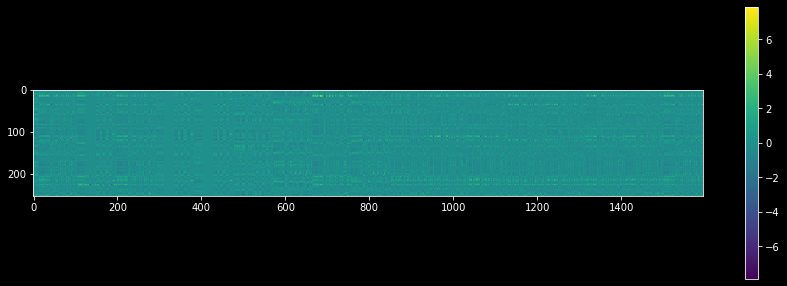

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 6381)
LassoCV score for 3 is [0.76995605] from dataset of size (68, 3381)
LassoCV score for 4 is [0.82003357] from dataset of size (68, 5381)
LassoCV score for 5 is [0.71918503] from dataset of size (68, 6381)
LassoCV score for 6 is [0.07604378] from dataset of size (68, 1)
LassoCV score for 7 is [0.81122931] from dataset of size (68, 6381)
LassoCV score for 8 is [0.77691356] from dataset of size (68, 6381)
LassoCV score for 9 is [0.77058706] from dataset of size (68, 6381)
Lasso predicts 0.7853 for case with 0.82 with selected CV 4 6381 features and 10 minority cases


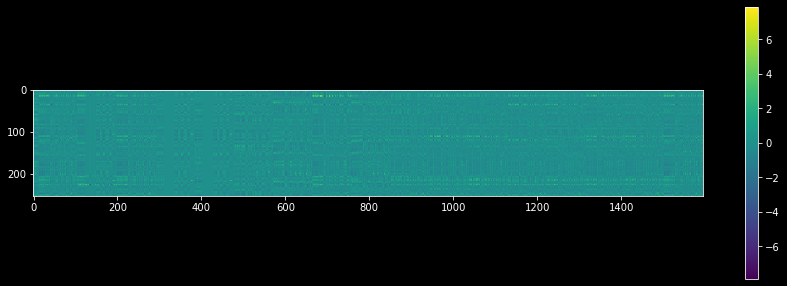

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1381)
LassoCV score for 3 is [0.45715155] from dataset of size (68, 2381)
LassoCV score for 4 is [0.89524934] from dataset of size (68, 3381)
LassoCV score for 5 is [0.79831084] from dataset of size (68, 5381)
LassoCV score for 6 is [0.71907819] from dataset of size (68, 6381)
LassoCV score for 7 is [0.75106317] from dataset of size (68, 6381)
LassoCV score for 8 is [0.79478091] from dataset of size (68, 5381)
LassoCV score for 9 is [0.75762666] from dataset of size (68, 6381)
Lasso predicts 0.5789 for case with 0.67 with selected CV 4 6381 features and 10 minority cases


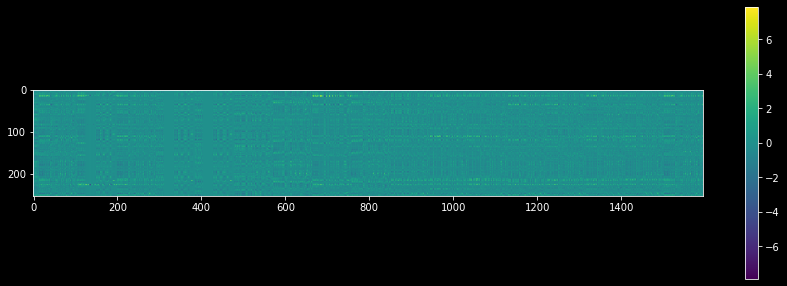

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1)
LassoCV score for 3 is [0.94435108] from dataset of size (68, 1381)
LassoCV score for 4 is [0.78315061] from dataset of size (68, 4381)
LassoCV score for 5 is [0.87323812] from dataset of size (68, 4381)
LassoCV score for 6 is [0.5982282] from dataset of size (68, 6381)
LassoCV score for 7 is [0.78113566] from dataset of size (68, 6381)
LassoCV score for 8 is [0.76485387] from dataset of size (68, 6381)
LassoCV score for 9 is [0.77245016] from dataset of size (68, 6381)
Lasso predicts 0.5739 for case with 0.71 with selected CV 3 1 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1)
LassoCV score for 3 is [0.7106032] from dataset of size (68, 2381)
LassoCV score for 4 is [0.62716292] from dataset of size (68, 6381)
LassoCV score for 5 is [0.74991703] from dataset of size (68, 6381)
LassoCV score for 6 is [0.73985354] from dataset of size (68, 6381)
LassoCV score for 7 is [0.80005847] from dataset of size (68, 6381)
LassoCV score for 8 is [0.75987256] from dataset of size (68, 6381)
LassoCV score for 9 is [0.78444633] from dataset of size (68, 6381)
Lasso predicts 0.8501 for case with 0.78 with selected CV 7 5381 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 3381)
LassoCV score for 3 is [0.64707031] from dataset of size (68, 2381)
LassoCV score for 4 is [0.86426453] from dataset of size (68, 3381)
LassoCV score for 5 is [0.82538452] from dataset of size (68, 6381)
LassoCV score for 6 is [0.7458929] from dataset of size (68, 6381)
LassoCV score for 7 is [0.82441028] from dataset of size (68, 6381)
LassoCV score for 8 is [0.08414053] from dataset of size (68, 1)
LassoCV score for 9 is [0.78836266] from dataset of size (68, 6381)
Lasso predicts 0.7422 for case with 0.69 with selected CV 4 6381 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 3381)
LassoCV score for 3 is [0.46481961] from dataset of size (68, 6381)
LassoCV score for 4 is [0.84134937] from dataset of size (68, 4381)
LassoCV score for 5 is [0.95131041] from dataset of size (68, 6381)
LassoCV score for 6 is [0.83432645] from dataset of size (68, 5381)
LassoCV score for 7 is [0.86793858] from dataset of size (68, 6381)
LassoCV score for 8 is [0.78504067] from dataset of size (68, 5381)
LassoCV score for 9 is [0.80793036] from dataset of size (68, 6381)
Lasso predicts 0.4354 for case with 0.62 with selected CV 5 5381 features and 10 minority cases


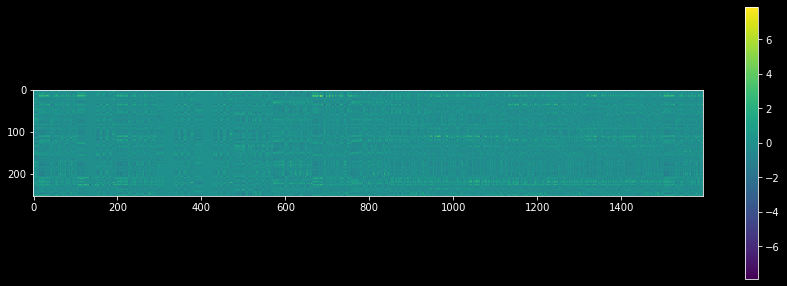

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.01597324] from dataset of size (68, 381)
LassoCV score for 3 is [0.5903041] from dataset of size (68, 2381)
LassoCV score for 4 is [0.65811999] from dataset of size (68, 6381)
LassoCV score for 5 is [0.71579914] from dataset of size (68, 6381)
LassoCV score for 6 is [0.74061292] from dataset of size (68, 6381)
LassoCV score for 7 is [0.85327544] from dataset of size (68, 6381)
LassoCV score for 8 is [0.82885401] from dataset of size (68, 5381)
LassoCV score for 9 is [0.79473724] from dataset of size (68, 6381)
Lasso predicts 0.657 for case with 0.56 with selected CV 7 5381 features and 10 minority cases


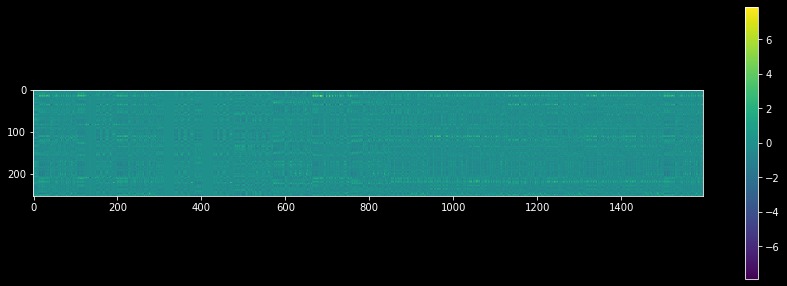

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 3381)
LassoCV score for 3 is [0.96914323] from dataset of size (68, 2381)
LassoCV score for 4 is [0.84001945] from dataset of size (68, 3381)
LassoCV score for 5 is [0.99971823] from dataset of size (68, 6381)
LassoCV score for 6 is [0.76601147] from dataset of size (68, 6381)
LassoCV score for 7 is [0.85674238] from dataset of size (68, 6381)
LassoCV score for 8 is [0.7800772] from dataset of size (68, 6381)
LassoCV score for 9 is [0.85033933] from dataset of size (68, 5381)
Lasso predicts 0.3469 for case with 0.6 with selected CV 5 5381 features and 10 minority cases


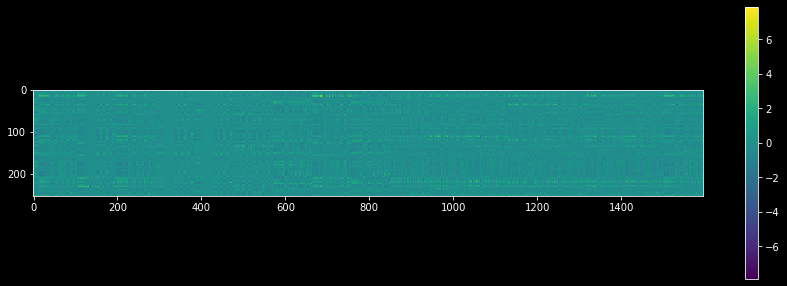

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.02250422] from dataset of size (68, 381)
LassoCV score for 3 is [0.65672378] from dataset of size (68, 2381)
LassoCV score for 4 is [0.98371353] from dataset of size (68, 1381)
LassoCV score for 5 is [0.796176] from dataset of size (68, 6381)
LassoCV score for 6 is [0.90109373] from dataset of size (68, 6381)
LassoCV score for 7 is [0.85145945] from dataset of size (68, 6381)
LassoCV score for 8 is [0.77776788] from dataset of size (68, 6381)
LassoCV score for 9 is [0.88949381] from dataset of size (68, 5381)
Lasso predicts 0.7544 for case with 0.61 with selected CV 4 5381 features and 10 minority cases


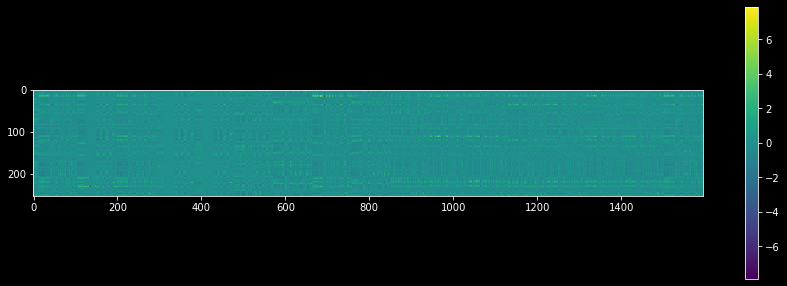

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.01271894] from dataset of size (68, 381)
LassoCV score for 3 is [0.95239989] from dataset of size (68, 1381)
LassoCV score for 4 is [0.99721967] from dataset of size (68, 3381)
LassoCV score for 5 is [0.85380431] from dataset of size (68, 6381)
LassoCV score for 6 is [0.70803903] from dataset of size (68, 6381)
LassoCV score for 7 is [0.90299887] from dataset of size (68, 6381)
LassoCV score for 8 is [0.79744871] from dataset of size (68, 5381)
LassoCV score for 9 is [0.06945684] from dataset of size (68, 1)
Lasso predicts 0.6813 for case with 0.63 with selected CV 4 6381 features and 10 minority cases


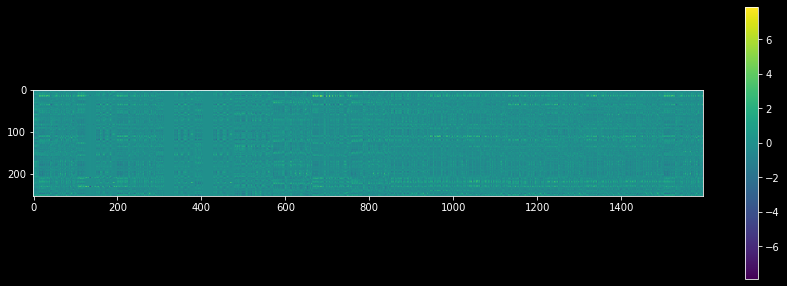

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.20027488] from dataset of size (68, 381)
LassoCV score for 3 is [0.69709716] from dataset of size (68, 4381)
LassoCV score for 4 is [0.9141537] from dataset of size (68, 3381)
LassoCV score for 5 is [0.85879314] from dataset of size (68, 6381)
LassoCV score for 6 is [0.73015995] from dataset of size (68, 4381)
LassoCV score for 7 is [0.8372374] from dataset of size (68, 6381)
LassoCV score for 8 is [0.84813387] from dataset of size (68, 4381)
LassoCV score for 9 is [0.77204228] from dataset of size (68, 6381)
Lasso predicts 0.6832 for case with 0.94 with selected CV 4 1 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 2381)
LassoCV score for 3 is [0.08383174] from dataset of size (68, 1)
LassoCV score for 4 is [0.68460832] from dataset of size (68, 6381)
LassoCV score for 5 is [0.89412451] from dataset of size (68, 5381)
LassoCV score for 6 is [0.72682239] from dataset of size (68, 6381)
LassoCV score for 7 is [0.87230463] from dataset of size (68, 6381)
LassoCV score for 8 is [0.78836522] from dataset of size (68, 6381)
LassoCV score for 9 is [0.76996334] from dataset of size (68, 6381)
Lasso predicts 0.6256 for case with 0.61 with selected CV 5 2381 features and 10 minority cases


Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 381)
LassoCV score for 3 is [0.87150652] from dataset of size (68, 4381)
LassoCV score for 4 is [0.97977239] from dataset of size (68, 3381)
LassoCV score for 5 is [0.96788852] from dataset of size (68, 3381)
LassoCV score for 6 is [0.91086472] from dataset of size (68, 5381)
LassoCV score for 7 is [0.90673425] from dataset of size (68, 6381)
LassoCV score for 8 is [0.91994465] from dataset of size (68, 5381)
LassoCV score for 9 is [0.8252475] from dataset of size (68, 6381)
Lasso predicts 0.9089 for case with 0.45 with selected CV 4 3381 features and 10 minority cases


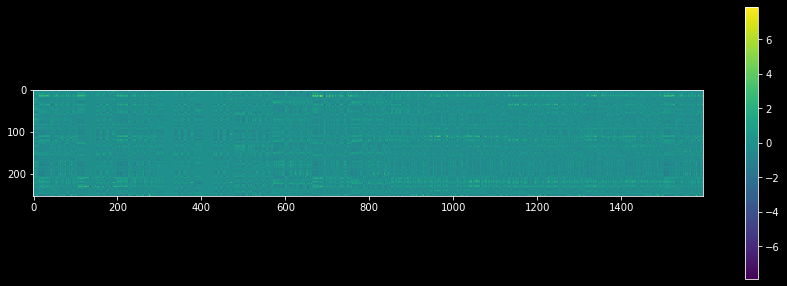

Resampled to size (64,)
Resampled to size (65,)
Resampled to size (66,)
Resampled to size (67,)
Resampled to size (68,)
LassoCV score for 2 is [0.] from dataset of size (68, 1381)
LassoCV score for 3 is [0.66614429] from dataset of size (68, 2381)
LassoCV score for 4 is [0.92391173] from dataset of size (68, 5381)
LassoCV score for 5 is [0.86869734] from dataset of size (68, 4381)
LassoCV score for 6 is [0.98290619] from dataset of size (68, 6381)
LassoCV score for 7 is [0.89362919] from dataset of size (68, 6381)
LassoCV score for 8 is [0.86897276] from dataset of size (68, 6381)
LassoCV score for 9 is [0.78599102] from dataset of size (68, 6381)
Lasso predicts 0.6182 for case with 0.62 with selected CV 6 1 features and 10 minority cases


In [14]:
retrain = 1
if retrain == 1:

  Js = []
  aug = False
  # err_var = np.zeros_like(per_change)
  # rerror = np.zeros_like(per_change)
  # kappa = []
  # K_nz = []
  # E_nz = []
  c = 0

  K_all_c = np.append(K_all_c,['pre updrs']*5)
  for j in np.arange(len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_all_c[train_index,:,:]
      X_test = X_all_c[test_index,:,:]
      y_train = per_change[train_index]
      y_test = per_change[test_index]

      y_cat = y_train <= 0.3
      idy = np.where(y_cat==1)
      # Cross validation
                                            
      X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs,None,None,None,None,None,None,None,None,None,False,False,False)
      plt.imshow(X0_ss0[:,:-1].reshape(-1,1595),cmap='viridis')
      plt.colorbar()
      plt.show()
      cvn = 10
      cv_scores = np.zeros((cvn,1))
      # cv_lgr_scores = np.zeros((cvn,1))
      rs = 1
      rcfs = 1000
      (mu, sigma) = stats.norm.fit(y_train)
      kappa = stats.skew(y_train)
      # print('Label distribution of:',mu,sigma,kappa)
      for jj in np.arange(2,cvn):
        # Resample to avoid stratification errors
        while np.sum(y_cat) < cvn:
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
          y_train = np.append(y_train,y_train[idyr])
          y_cat = y_train <= 0.3
          rs = rs+1
          print('Resampled to size',y_train.shape)
        if aug == True:
          # y_train_n = y_train+(1.96*sigma)*np.random.normal(0,1,1)
          z_train = (y_train-np.mean(y_train))/(np.std(y_train)/np.sqrt(len(y_train)))
          z_train_ns = z_train+1.96*np.std(z_train)*np.random.normal(0,1,1)
          y_train_n = z_train_ns*((np.std(y_train)/np.sqrt(len(y_train))))+np.mean(y_train)
          y_train = np.hstack((y_train,y_train_n))
          y_cat = y_train <= 0.3
          X0_ss0 = np.vstack((X0_ss0,X0_ss0))
      
      for jj in np.arange(2,cvn):
        skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
        skf_gen = skf_g.split(X0_ss0,y_cat)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None)
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
          # Feature selection
          warnings.filterwarnings("ignore", category=ConvergenceWarning)
          sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen,n_jobs=1)
          # Stratifies classifiers automatically
          #sel_lr = skf.SelectKBest(r_regression,k=1500)#skf.RFECV(lgr,step=rcfs,cv=jj,n_jobs=1)
          X0_ss = sel.fit_transform(X0_ss0,y_train)
          # X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
          est_ls = lasso.fit(X0_ss,y_train)
          # est_lgr = lgr.fit(X0_ssl,y_cat)
          cv_scores[jj] = est_ls.score(X0_ss,y_train)
          # cv_lgr_scores[jj] = est_lgr.score(X0_ssl,y_cat)
          print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
          
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
        best_cv = np.argmax(cv_scores)
        # best_cv_lgr = np.argmax(cv_lgr_scores)

        # Break any ties
        if np.sum(cv_scores == best_cv) > 1:
          cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
          # cv_lgr_scores_tb = np.zeros((np.sum(cv_scores == best_cv_lgr),1))
          for jjj in (cv_scores == cv_scores[best_cv]):
            if jjj > 0:
              print('Breaking tie')
              skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
              skf_gen = skf_g.split(X0_ss0,y_cat) 
              X0_ss = sel.fit_transform(X0_ss0,y_train)
              # X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
              est_ls = lasso.fit(X0_ss,y_train)
              # est_lgr = lgr.fit(X0_ssl,y_cat)
              lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
              # lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None)
              est_ls = lasso.fit(X0_ss,y_train)
              # est_lgr = lgr.fit(X0_ssl,y_cat)
              cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
              # cv_lgr_scores_tb[jj] = est_lgr.score(sel_lr.fit_transform(X0_ss0,y_cat),y_cat)
          best_cv = np.argmax(cv_scores_tb)
          # best_cv_lgr = np.argmax(cv_lgr_scores_tb)
        
        # Fit whole dataset with optimal cv
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        # lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None)
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        # sel_lr = skf.RFECV(lgr,step=rcfs,cv=best_cv)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X_test_ss = sel.transform(X_test_ss0)
        # X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
        # X_test_ssl = sel_lr.transform(X_test_ss0)
        #K_ss = sel.transform(K_all_c.reshape(1,-1))

      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        # lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=best_cv,class_weight=None)
        est_ls = lasso.fit(X0_ss,y_train)

        # est_lgr = lgr.fit(X0_ssl,y_cat)
      # results_lgr_aug[c] = est_lgr.predict(X_test_ssl)
      # results_lgrp_aug[c] = est_lgr.predict_proba(X_test_ssl)[0][0]
      results_ls_aug[c] = est_ls.predict(X_test_ss)
      print('Lasso predicts',str(np.round(results_ls_aug[c],4)),
                'for case with',str(np.round((per_change)[c],2)),
                'with selected CV',best_cv,
                X0_ss.shape[1],'features',
                'and',sum(y_cat),'minority cases')
      # K_nz.append(np.squeeze(K_ss)[est_ls.coef_>0])
      # E_nz.append(est_ls.coef_[est_ls.coef_>0])
      c=c+1

  # np.save('results_ls_aug_d.npy',results_ls_aug)
  # np.save('results_lgr_aug_d.npy',results_lgr_aug)
  # np.save('results_lgrp_aug_d.npy',results_lgrp_aug)

else:
  print('Loading')
  # results_ls_aug = np.load('results_ls_aug_d.npy')
  # results_lgr_aug = np.load('results_lgr_aug_d.npy')
  #results_lgrp_aug = np.load('results_lgr_aug_d.npy')

  


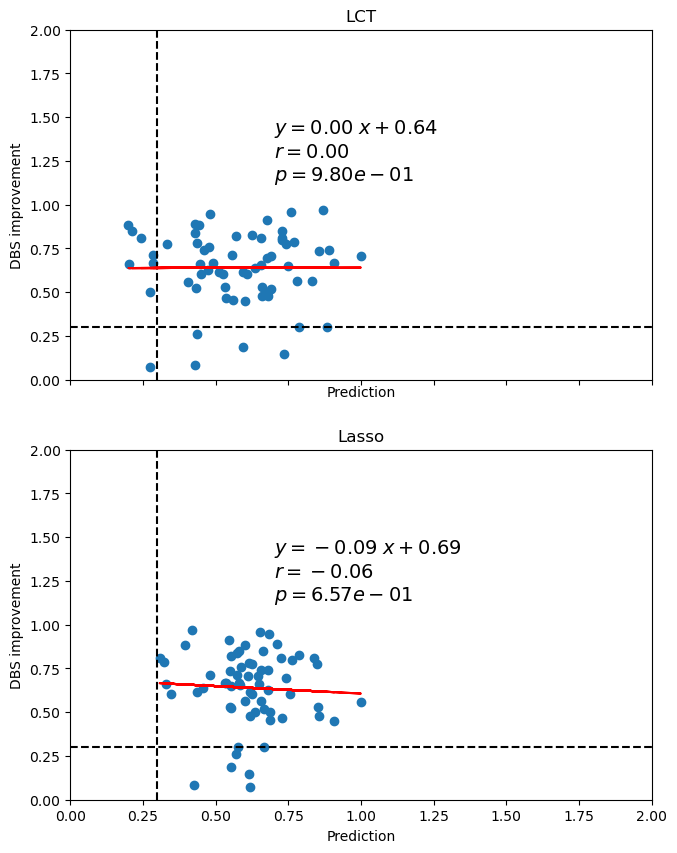

In [16]:
results_ls_aug[results_ls_aug>1]=1
util.eval_prediction(np.vstack((pre_imp,
                               results_ls_aug,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')